# Cross Validation
Durante la **construcción de un modelo se toman decisiones** como qué variables utilizar, qué tipo de modelo, parámetros, etc, todo esto con el fin de **mejorar la performance** de nuestro modelo. Esta performance la medimos por medio de un set de validación, pero este método tiene sus contras, por ejemplo, supongamos un set de datos de unas 5000 filas, de las cuales (normalmente) tomamos el 20% para validación (unas 1000 filas). Entonces, nos encontraremos con cierto azar en nuestra medida de la calidad del modelo, ya que puede funcionar muy bien en un determinado set de 1000 filas pero no así en otro. La manera en que podríamos evitar esto sería agrandando el set de validación, pero esto implicaría reducir el de entrenamiento, por tanto nos dejaría un modelo más pobre.

Para **solucionar este conflicto, se presenta la *cross-validation***. Consiste en **repetir el proceso de entrenamiento/validación tomando en cada iteración un bloque distinto del dataset como *validation data***. De esta manera, al finalizar, tendremos una medida de la **calidad del modelo que se basa en todos los datos del dataset** completo (aunque no se usen en simultáneo)
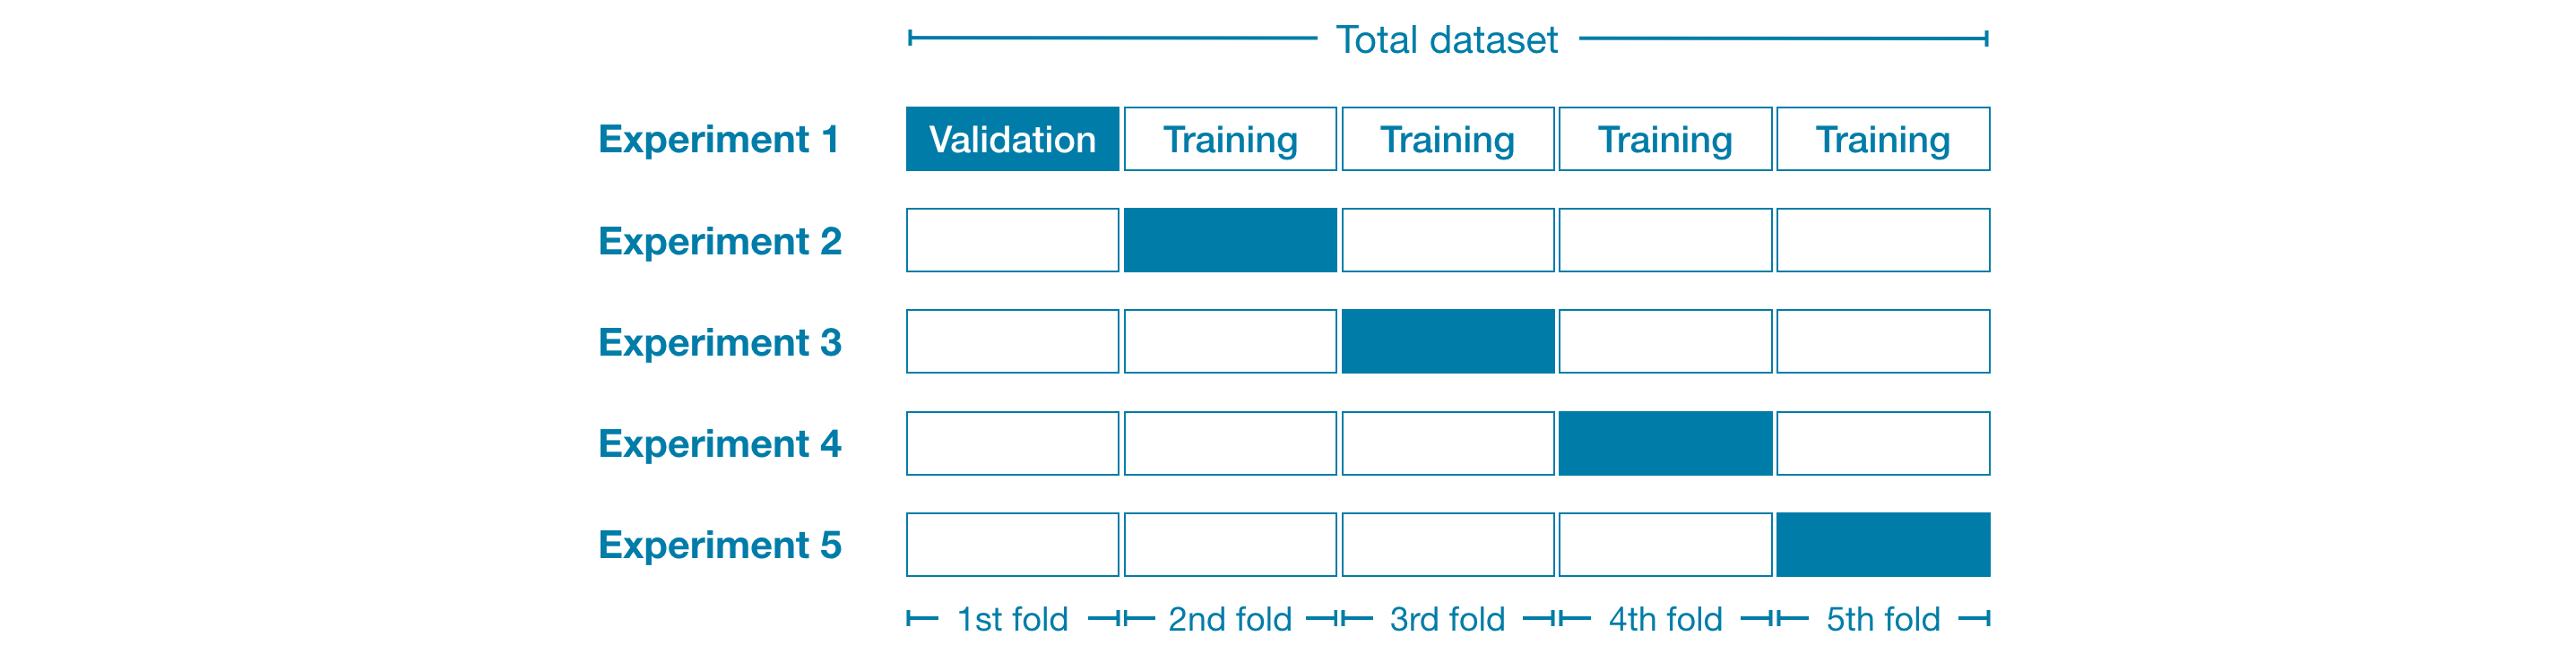


## Cuándo usarlo
Este método nos da una buena medida de la calidad del modelo pero, como contrapartida, tarda mucho en ejecutarse. Entonces:
- **Datasets pequeños**, el gasto computacional extra no es tan grane -> **Podemos usar *cross-validation***
- **Datasets grandes**, 1 solo set de validación será suficiente y el código correrá más rápido -> **No usar *cross-validation***

No hay un límite claro para definir un dataset como pequeño o grande, pero podremos probarlo en ejecución, por ejemplo, midiendo cuánto tarda en ejecutar el programa o, al realizar varias pruebas múltiples, si arrojan resultados similares podemos decir que un *single-validation+ será suficiente.

**IMPORTANTE:** el código es mucho más limpio, ya no tenemos que andar repitiendo procesos sobre *train/validation data*.

**NOTA:** recordar que utiliza *neg_mean_absolute_error* por convención de *scikit* donde se toma como "mejor" a los números mayores, por tanto, para compatibilidad, en el caso del error donde un menor error es mejor, se los convierte a negativo, de tal manera un número menos negativo (mayor) será mejor.

## Práctica
Veamos un ejercicio de aplicación, primero un simple uso de cross-validation:

In [1]:
import pandas as pd

train_data = pd.read_csv('assets/input/train.csv')

train_data.dropna(subset=['SalePrice'], axis=0, inplace=True)
y = train_data.SalePrice
train_data.drop(['SalePrice'], axis=1, inplace=True)

# Por simpleza, solo features numericos
X = train_data.select_dtypes(exclude=['object'])
print('Listo.')

Listo.


In [35]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

model_pipe = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', RandomForestRegressor(n_estimators=50, random_state=1))
])

scores = -1 * cross_val_score(model_pipe, X, y, cv=5, scoring='neg_mean_absolute_error')
print('MAE (cada bloque) cross validation:', scores)
print('\nMAE (average) cross validation: {:.0f}'.format(scores.mean()))

MAE (cada bloque) cross validation: [18714.86486301 18355.11315068 18455.65506849 16562.69212329
 19998.16561644]

MAE (average) cross validation: 18417


Ahora, continuamos con la realización de una función que nos permita evaluar la performance de un modelo de predicción, en función de distintos valores para el parámetro *n_estimators*, basándose en el MAE obtenido por medio de cross validation.

Esta es una manera sencilla de elegir el modelo a utilizar a la hora de realizar un proyecto.

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def get_score(n_estimators):
    ''' Devuelve el score de un modelo, analizado por cross-validation
        (utilizando cv=3)
        @params: 
            - n_estimators: estimadores del modelo
    '''
    model = RandomForestRegressor(n_estimators= n_estimators, random_state=0)
    # por simpleza trabajamos solo con features numericas 
    # Processor es solo un SimpleImputer 
    model_pipe = Pipeline(steps=[
        ('preprocessor', SimpleImputer()),
        ('model', model)
    ])
    
    scores = -1 * cross_val_score(model_pipe, X, y, cv=3, scoring='neg_mean_absolute_error')
    return scores.mean()

In [37]:
# analizo modelos: n_estimators = [50,100,...,400]
cand_estimators = range(50, 450, 50)
model_scores = {n_est: get_score(n_est) for n_est in cand_estimators}

Valor de n_estimators con minimo error:  250


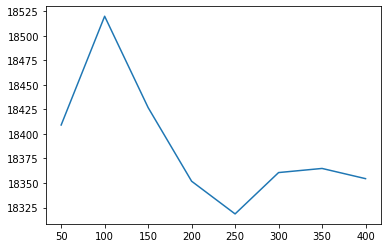

In [39]:
# ¿Cual n_estimators da mejor resultado?
import matplotlib.pyplot as plt
%matplotlib inline

# Grafico MAE (average, por cross-validation) segun n_estimators
plt.plot(model_scores.keys(), model_scores.values())


# usando de min
best_n_estimator = min(model_scores.keys(), key=(lambda k: model_scores[k]))
print('Valor de n_estimators con minimo error: ', best_n_estimator)

## Uso lo aprendido para Competencia
Habiendo visto el método anterior para analizar modelos en función de los *n_estimators* lo aplico para obtener el mejor modelo predictivo en mi ejercicio de la competencia de *House Pricing* (teniendo en cuenta el preprocesamiento que utilicé, que arrojó el mejor resultado hasta ahora). Esto sería como un ajuste fino, sólo en función de los estimadores, en este caso.

In [2]:
# Carga inicial de Data
train_data = pd.read_csv('assets/input/train.csv', index_col='Id')
test_data = pd.read_csv('assets/input/test.csv', index_col='Id')

train_data.dropna(subset=['SalePrice'], axis=0, inplace=True)
y = train_data.SalePrice
X_full = train_data.drop(['SalePrice'], axis=1)

# al usar OrdinalEncoder con handle_unknown no necesito filtrar Variables Catergoricas 
# ni por Cardinalidad (OneHot) 
# ni por subset (valores que no estan en el entrenamiento y si en la prediccion)
X = X_full

# es necesario para el pipeline nomas (como dije no filtro nada)
num_cols = [col for col in X_full.columns if X_full[col].dtype in ['int64', 'float64']]
catg_cols = [col for col in X_full.columns if X_full[col].dtype == 'object' ]
print('Listo')

Listo


In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

# defino el Preprocessor fuera de la funcion, 
# para tenerlo disponible luego
numeric_transformer = SimpleImputer(strategy='median')
categoric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=30))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categoric_transformer, catg_cols),
])


# get_scores modificado para aplicacion especifica
# uso el preprocesamiento realizado en Clase 4
def get_scores_comp(n_estimators):
    ''' Devuelve el score de un modelo, analizado por cross-validation
        (utilizando cv=3)
        @params: 
            - n_estimators: estimadores del modelo
    '''    
    model = RandomForestRegressor(n_estimators= n_estimators, random_state=0)
    model_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    scores = -1 * cross_val_score(model_pipe, X, y, cv=3, scoring='neg_mean_absolute_error')
    return scores.mean()

In [18]:
# analizo modelos: n_estimators = [50,100,...,400]
cand_estimators = range(50, 450, 50)
model_scores = {n_est: get_scores_comp(n_est) for n_est in cand_estimators}

{50: 17910.6216834684,
 100: 17996.01130794343,
 150: 17889.22960737755,
 200: 17873.220741332254,
 250: 17843.424077871012,
 300: 17880.841414542156,
 350: 17873.165687257282,
 400: 17874.250221380025}

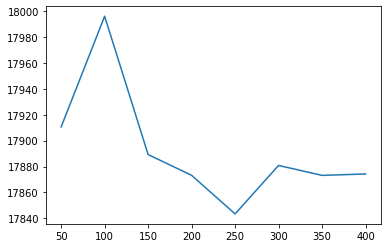

In [19]:
# ¿Cual n_estimators da mejor resultado?
import matplotlib.pyplot as plt
%matplotlib inline

# Grafico MAE (average, por cross-validation) segun n_estimators
plt.plot(model_scores.keys(), model_scores.values())

Del análisis previo, concluimos que **para nuestro modelo utilizado en la competencia, con el preprocesamiento dado, el mejor parámetro de *n_estimators* es 250**.

Realizamos el entrenamiento final, y las predicciones sobre el dataset *test.csv* (aunque la mejora en el error, es pequeña, pero vamos a ver qué resultado arroja).

In [24]:
# no se filtro ninguna feature (se procesan todas)
test_X = test_data

# post analisis f(n_estimators) mediante cross-validation
final_model = RandomForestRegressor(n_estimators= 250, random_state=0)
final_model_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', final_model)
])

final_model_pipe.fit(X, y)
test_preds = final_model_pipe.predict(test_X)

In [25]:
output = pd.DataFrame({'Id': test_X.index, 'SalePrice': test_preds})
output.to_csv('assets/output/home_submission_pipe_crssval.csv', index=False)

Finalmente, el ***score* que obtuvo fue de 15837**, mejorando el previo, que era de 18880 aproximadamente.